Code based on: https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Flatten, Dense, Reshape
from keras import backend as K
import matplotlib.pyplot as plt
import os
%matplotlib inline

C:\Users\XE89IW.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Data (MNIST)
Import the MNIST dataset, normalise and reshape it.

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

img_rows, img_cols, chns = 28, 28, 1

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

11493376/11490434 [==============================] - 44s 4us/step


### Adding noise
We obtain a noisy version of our data by adding Gaussian (normal) noise to each pixel, and clipping pixel values between 0 and 1.

In [3]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [4]:
print(x_train.shape)
print(x_train_noisy.shape)
print(x_test.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(10000, 28, 28, 1)


Let's visualise some examples from the original test set as well as their noisy version.

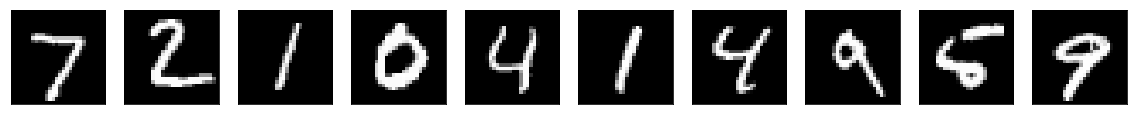

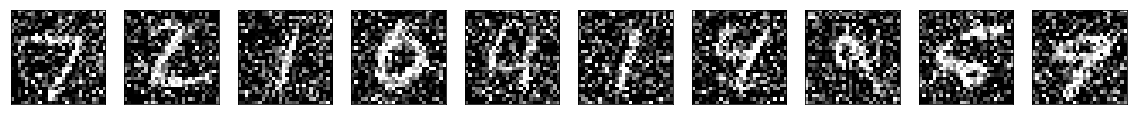

In [5]:
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

plot_examples(x_test)
plot_examples(x_test_noisy)

# Model architecture & settings

For the encoder we will use convolutional layers and Max-Pooling (to down-sample the image), followed by a Dense layer. This gives a hidden "code" of 128 dimensions. For the decoder we use a Dense layer to upscale to the same dimension before convolutional layers and UpSampling. We also include Batch Normalization, which significantly speeds up training.

More precisely, for the encoder we will use the following architecture:
* Convolutional layer
* MaxPooling
* Batch Normalization
* Convolutional layer
* MaxPooling
* Batch Normalization
* Dense layer

From this we obtain a 128-dimensional encoded representation, this is the "code" of the autoencoder.

The decoder will have the following architecture:
* Dense layer (to reshape/upsample to a suitable representation for the next convolutional layer)
* Convolutional layer
* UpSampling
* Batch Normalization
* Convolutional layer
* UpSampling
* Batch Normalization
* Convolutional layer (this layer should generate ouput images, of the same format as the input of the encoder)

All convolutional layers (except for the output layer) will have 32 filters (feature maps), a kernel size of 3x3, strides of 1x1, "ReLU" activations and "same" padding. All MaxPooling and UpSampling operations will have size 2x2. To connect a convolutional layer after a Dense layer, use a Reshape layer to transform the data to the right shape for convolutions.

The final convolutional layer should produce images in the same format as the input. It will have a kernel size of 3x3, and use "same" padding. Think of a suitable activation, and the right number of filters.

Optional: output a summary of the architecture.

Compile the model to use the "adam" optimizer, with a suitable loss function.

In [6]:
autoencoder = Sequential()

# encoder
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(MaxPooling2D((2, 2), padding='same'))  # at this point the representation is (7, 7, 32)
autoencoder.add(BatchNormalization())
autoencoder.add(Flatten())  # the representation is now a flat vector of dimension 7*7*32 = 1568
autoencoder.add(Dense(128, activation='relu', name="neural_codes"))  # name this "neural_codes" to retrieve as codes later


# decoder
autoencoder.add(Dense(1568))  # obtain representation that can be reshaped to (7, 7, 32)
autoencoder.add(Reshape((7, 7, 32)))
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 32)          128       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
__________

# Training the model
Train the model (using stochastic gradient descent) with given batch size, for given number of epochs. We split of 1/12-th of the data (5,000 of the 60,000 samples) as validation data, such that we can use the validation accuracy for hyperparameter tuning. Since the model includes batch normalization, we don't need to train for many epochs to achieve reasonable results.

Note that we use the noisy data as input and the original data as target, such that the model learns to denoise the data.

In [7]:
batch_size = 100
epochs = 10

autoencoder.fit(x_train_noisy, x_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 30s 537us/step - loss: 0.1689 - val_loss: 0.1111
Epoch 2/10
55000/55000 [==============================] - 27s 485us/step - loss: 0.1066 - val_loss: 0.1047
Epoch 3/10
55000/55000 [==============================] - 27s 486us/step - loss: 0.1020 - val_loss: 0.1028
Epoch 4/10
55000/55000 [==============================] - 27s 487us/step - loss: 0.0997 - val_loss: 0.1007
Epoch 5/10
55000/55000 [==============================] - 27s 486us/step - loss: 0.0983 - val_loss: 0.0996
Epoch 6/10
55000/55000 [==============================] - 27s 486us/step - loss: 0.0970 - val_loss: 0.0980
Epoch 7/10
55000/55000 [==============================] - 27s 485us/step - loss: 0.0960 - val_loss: 0.0976
Epoch 8/10
55000/55000 [==============================] - 27s 487us/step - loss: 0.0953 - val_loss: 0.0983
Epoch 9/10
55000/55000 [==============================] - 27s 485us/step - loss: 0.0946 - val_l

# Evaluating the model
We cannot use an accuracy measure here like in supervised learning, since there are no target labels. We can compute a loss value for the test set, but this doesn't provide an intuitive result. Therefore we will also inspect a few reconstructions visually. First we use the autoencoder to denoise the test set, then we visualise a few examples (the original images, the noisy versions, and their denoised reconstructions).

10000/10000 [==============================] - 1s 135us/step
Test loss: 0.09730779103934765


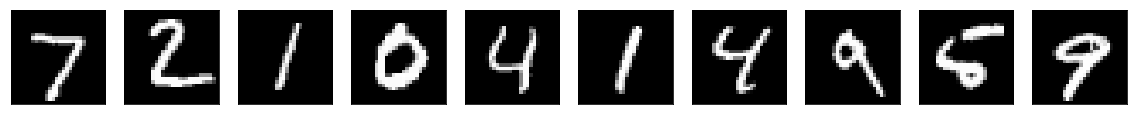

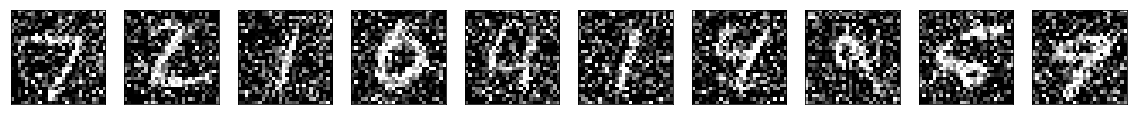

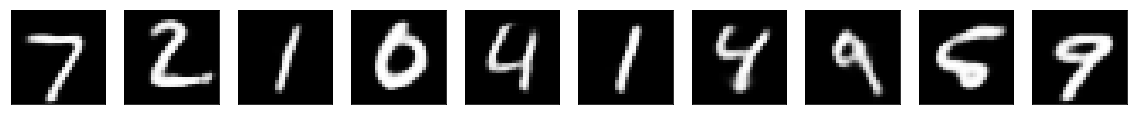

In [8]:
test_loss = autoencoder.evaluate(x_test_noisy, x_test, batch_size=batch_size)
print("Test loss:", test_loss)

x_test_reconstr = autoencoder.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr)

# Saving the model
We save the model to a .h5 file, such that we can load it later in other notebooks.

In [9]:
autoencoder.save(os.path.join("models", "dae_mnist.h5"))